<a href="https://colab.research.google.com/github/SLy-Precision/Player-Selection-and-Optimization-for-Roster/blob/main/01_Preprocess_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Statsbomb api and more
!pip install --quiet statsbombpy
!pip install --quiet mplsoccer
!pip install --quiet highlight_text
!pip install --quiet mplsoccer
!pip install --quiet highlight_text

# Libraries for the data manipulation and plot
from statsbombpy import sb
from tqdm import tqdm
import pandas as pd
from mplsoccer import VerticalPitch, Pitch, Sbapi
from highlight_text import ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import numpy as np


In [ ]:
# Creation of a function to extract all the events for every game and season
def process_season_dynamically(competition_id, season_id, creds, output_filename, num_matches=None):
    """
    This Function extract all the events in a single game and for all the games in a season,
    if num:matches=None this will extract all the games in the season, for any other select a
    Natural
    """
    print(f"--- Starting extraction for the ID: {season_id} ---")

    try:
        matches = sb.matches(competition_id=competition_id, season_id=season_id, creds=creds)

        # Checking number of games
        if num_matches is not None and num_matches > 0:
            print(f"Procesing a subset from {num_matches} games.")
            matches_to_process = matches.head(num_matches)
        else:
            print(f"Processing all the {len(matches)} games in the season.")
            matches_to_process = matches

        # Recolect event in types
        print("\nRecolecting events in the selected games...")
        all_events_raw = []
        for index, match_info in tqdm(matches_to_process.iterrows(), total=matches_to_process.shape[0], desc="Recolectando Partidos"):
            match_id = match_info['match_id']
            df_events = sb.events(match_id=match_id, creds=creds)

            df_events['match_id'] = match_id
            df_events['home_team_name'] = match_info['home_team']

            all_events_raw.append(df_events)

        if not all_events_raw:
            print("No events found in the selcted games.")
            return None

        df_full_season = pd.concat(all_events_raw, ignore_index=True)
        df_full_season = df_full_season[df_full_season['type'] != 'Starting XI'].copy()

        # Dynamic maping in the events
        unique_event_types = df_full_season['type'].unique()
        event_map = {event_name: i for i, event_name in enumerate(unique_event_types)}

        print("\n--- Map of the events (Dynamic generated) ---")
        for name, idx in event_map.items():
            print(f"'{name}': {idx}")
        print("-------------------------------------------------")

        df_full_season['EventTypeId'] = df_full_season['type'].map(event_map)

        # Applying tranformations
        print("\nApplying transformations to the data...")
        df = df_full_season.sort_values(by=['match_id', 'period', 'timestamp']).reset_index(drop=True)

        df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f', errors='coerce')
        df['eventSec'] = df['timestamp'].dt.hour * 3600 + df['timestamp'].dt.minute * 60 + df['timestamp'].dt.second + df['timestamp'].dt.microsecond / 1e6

        df = df.rename(columns={'period': 'Period', 'minute': 'Minute'})
        df['x_coord'] = df['location'].apply(lambda loc: loc[0] if isinstance(loc, list) and len(loc) > 0 else np.nan)
        df['y_coord'] = df['location'].apply(lambda loc: loc[1] if isinstance(loc, list) and len(loc) > 1 else np.nan)

        df['X'] = (df['x_coord'] / 120) * 100
        df['Y'] = (df['y_coord'] / 80) * 100
        df[['X', 'Y']] = df[['X', 'Y']].fillna(50)

        home_team_ids = df.loc[df['team'] == df['home_team_name'], ['match_id', 'team_id']].drop_duplicates().set_index('match_id')
        df['home_team_id'] = df['match_id'].map(home_team_ids['team_id'])
        df['IsHomeTeam'] = (df['team_id'].fillna(0) == df['home_team_id']).astype(int)

        df['IsGoal'] = (df['shot_outcome'] == 'Goal').astype(int)

        def calculate_is_accurate(row):
            if row['type'] == 'Pass' and pd.isna(row['pass_outcome']): return 1
            if row['type'] == 'Shot' and row['shot_outcome'] in ['Goal', 'Saved', 'Post']: return 1
            if row['type'] == 'Dribble' and row['dribble_outcome'] == 'Complete': return 1
            if row['type'] == 'Duel' and row['duel_outcome'] in ['Won', 'Success In Play', 'Success Out']: return 1
            return 0
        df['IsAccurate'] = df.apply(calculate_is_accurate, axis=1)

        df['HomeGoal'] = (df['IsGoal'] == 1) & (df['IsHomeTeam'] == 1)
        df['AwayGoal'] = (df['IsGoal'] == 1) & (df['IsHomeTeam'] == 0)

        df.loc[:, 'HomeScore'] = df.groupby('match_id')['HomeGoal'].cumsum().shift(1).fillna(0)
        df.loc[:, 'AwayScore'] = df.groupby('match_id')['AwayGoal'].cumsum().shift(1).fillna(0)

        df['TimeDelta'] = df.groupby('match_id')['eventSec'].diff().fillna(0)

        final_columns = ['match_id', 'eventSec', 'EventTypeId', 'Period', 'Minute', 'X', 'Y', 'IsHomeTeam', 'IsAccurate', 'IsGoal', 'HomeScore', 'AwayScore', 'TimeDelta']
        df_final = df[final_columns].copy().rename(columns={'match_id': 'matchId'})

        df_final.to_csv(output_filename, index=False)
        print(f"\nProcess for the season {season_id} completed. Data saved in '{output_filename}'")
        return df_final

    except Exception as e:
        print(f"\nError processing the seasson {season_id}: {e}")
        return None

In [ ]:
# First season

# Credentials from ITAM (thanks)
user = "itam_hackathon@hudl.com"
password = "pGwIprel"
creds = {"user": user, "passwd": password}

# Process the whole season
df_season_full = process_season_dynamically(
    competition_id=73,
    season_id=108,
    creds=creds,
    output_filename="Temporada_Completa_2021-2022.csv",
    num_matches=None # All games in the season
)


--- Iniciando procesamiento para la temporada ID: 108 ---
Procesando todos los 342 partidos de la temporada.

Recolectando eventos de todos los partidos seleccionados...


Recolectando Partidos:   0%|          | 0/342 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/statsbombpy/sb.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  events = pd.concat([*events.values()], axis=0, ignore_index=True, sort=True)
/tmp/ipython-input-3476817276.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_events['home_team_name'] = match_info['home_team']
Recolectando Partidos:   0%|          | 1/342 [00:02<16:27,  2.90s/it]/usr/local/lib/python3.12/dist-packages/statsbombpy/sb.py:122:


--- Mapeo de Eventos Generado Dinámicamente ---
'Half Start': 0
'Pass': 1
'Ball Receipt*': 2
'Carry': 3
'Interception': 4
'Miscontrol': 5
'Duel': 6
'Clearance': 7
'Ball Recovery': 8
'Pressure': 9
'Dispossessed': 10
'Dribble': 11
'Block': 12
'Injury Stoppage': 13
'Referee Ball-Drop': 14
'Foul Committed': 15
'Foul Won': 16
'Shot': 17
'Goal Keeper': 18
'Dribbled Past': 19
'Half End': 20
'Substitution': 21
'Tactical Shift': 22
'Bad Behaviour': 23
'Own Goal Against': 24
'Own Goal For': 25
'Shield': 26
'50/50': 27
'Player Off': 28
'Player On': 29
'Offside': 30
'Error': 31
-------------------------------------------------

Aplicando transformaciones a los datos...

Procesamiento para la temporada 108 completado. Datos guardados en 'Temporada_Completa_2021-2022.csv'


In [ ]:
# Second Season
df_season_full = process_season_dynamically(
    competition_id=73,
    season_id=235,
    creds=creds,
    output_filename="Temporada_Completa_2022-2023.csv",
    num_matches=None
)


--- Iniciando procesamiento para la temporada ID: 235 ---
Procesando todos los 342 partidos de la temporada.

Recolectando eventos de todos los partidos seleccionados...


Recolectando Partidos:   0%|          | 0/342 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/statsbombpy/sb.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  events = pd.concat([*events.values()], axis=0, ignore_index=True, sort=True)
Recolectando Partidos:   0%|          | 1/342 [00:03<19:13,  3.38s/it]/usr/local/lib/python3.12/dist-packages/statsbombpy/sb.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  events = pd.concat([*events.values()], axis=0, ignore_index=True, sort=Tr


--- Mapeo de Eventos Generado Dinámicamente ---
'Half Start': 0
'Pass': 1
'Ball Receipt*': 2
'Carry': 3
'Pressure': 4
'Foul Committed': 5
'Foul Won': 6
'Block': 7
'Ball Recovery': 8
'Clearance': 9
'Duel': 10
'Interception': 11
'Dribble': 12
'Miscontrol': 13
'Shot': 14
'Goal Keeper': 15
'Dispossessed': 16
'Injury Stoppage': 17
'Bad Behaviour': 18
'Player Off': 19
'Player On': 20
'Offside': 21
'Referee Ball-Drop': 22
'Dribbled Past': 23
'Half End': 24
'Substitution': 25
'Tactical Shift': 26
'Shield': 27
'Error': 28
'50/50': 29
'Own Goal For': 30
'Own Goal Against': 31
-------------------------------------------------

Aplicando transformaciones a los datos...

Procesamiento para la temporada 235 completado. Datos guardados en 'Temporada_Completa_2022-2023.csv'


In [ ]:
# Third season
df_season_full = process_season_dynamically(
    competition_id=73,
    season_id=281,
    creds=creds,
    output_filename="Temporada_Completa_2023-2024.csv",
    num_matches=None
    )


--- Iniciando procesamiento para la temporada ID: 281 ---
Procesando todos los 340 partidos de la temporada.

Recolectando eventos de todos los partidos seleccionados...


Recolectando Partidos:   0%|          | 0/340 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/statsbombpy/sb.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  events = pd.concat([*events.values()], axis=0, ignore_index=True, sort=True)
Recolectando Partidos:   0%|          | 1/340 [00:04<22:37,  4.00s/it]/usr/local/lib/python3.12/dist-packages/statsbombpy/sb.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  events = pd.concat([*events.values()], axis=0, ignore_index=True, sort=Tr


--- Mapeo de Eventos Generado Dinámicamente ---
'Half Start': 0
'Pass': 1
'Ball Receipt*': 2
'Carry': 3
'Pressure': 4
'Dribble': 5
'Duel': 6
'Clearance': 7
'Dispossessed': 8
'Ball Recovery': 9
'Block': 10
'Foul Committed': 11
'Foul Won': 12
'Shot': 13
'Goal Keeper': 14
'Dribbled Past': 15
'Miscontrol': 16
'Player Off': 17
'Player On': 18
'Interception': 19
'50/50': 20
'Half End': 21
'Injury Stoppage': 22
'Substitution': 23
'Tactical Shift': 24
'Bad Behaviour': 25
'Referee Ball-Drop': 26
'Error': 27
'Shield': 28
'Offside': 29
'Own Goal For': 30
'Own Goal Against': 31
-------------------------------------------------

Aplicando transformaciones a los datos...

Procesamiento para la temporada 281 completado. Datos guardados en 'Temporada_Completa_2023-2024.csv'


In [ ]:
# Fourth season
df_season_full = process_season_dynamically(
    competition_id=73,
    season_id=317,
    creds=creds,
    output_filename="Temporada_Completa_2024-2025.csv",
    num_matches=None
)


--- Iniciando procesamiento para la temporada ID: 317 ---
Procesando todos los 340 partidos de la temporada.

Recolectando eventos de todos los partidos seleccionados...


Recolectando Partidos:   0%|          | 0/340 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/statsbombpy/sb.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  events = pd.concat([*events.values()], axis=0, ignore_index=True, sort=True)
Recolectando Partidos:   0%|          | 1/340 [00:03<19:16,  3.41s/it]/usr/local/lib/python3.12/dist-packages/statsbombpy/sb.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  events = pd.concat([*events.values()], axis=0, ignore_index=True, sort=Tr


--- Mapeo de Eventos Generado Dinámicamente ---
'Half Start': 0
'Pass': 1
'Ball Receipt*': 2
'Carry': 3
'Pressure': 4
'Dispossessed': 5
'Duel': 6
'Shield': 7
'Ball Recovery': 8
'Clearance': 9
'Interception': 10
'Miscontrol': 11
'Block': 12
'Shot': 13
'Goal Keeper': 14
'Dribble': 15
'Dribbled Past': 16
'Foul Committed': 17
'Foul Won': 18
'50/50': 19
'Tactical Shift': 20
'Half End': 21
'Error': 22
'Injury Stoppage': 23
'Substitution': 24
'Referee Ball-Drop': 25
'Player Off': 26
'Player On': 27
'Offside': 28
'Own Goal For': 29
'Own Goal Against': 30
'Bad Behaviour': 31
-------------------------------------------------

Aplicando transformaciones a los datos...

Procesamiento para la temporada 317 completado. Datos guardados en 'Temporada_Completa_2024-2025.csv'


In [ ]:
# Lets create a direction of the data we extracted
csv_files = [
    "Temporada_Completa_2021-2022.csv",
    "Temporada_Completa_2022-2023.csv",
    "Temporada_Completa_2023-2024.csv",
    "Temporada_Completa_2024-2025.csv"
]

In [ ]:
#Here we are gonna concatenate the dfs
all_dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    all_dfs.append(df)

df_combined = pd.concat(all_dfs, ignore_index=True)
display(df_combined.head())
display(df_combined.tail())

,matchId,eventSec,EventTypeId,Period,Minute,X,Y,IsHomeTeam,IsAccurate,IsGoal,HomeScore,AwayScore,TimeDelta
0,3799351,0.000,0,1,0,50.000000,50.000,1,0,0,0.0,0.0,0.000
1,3799351,0.000,0,1,0,50.000000,50.000,0,0,0,0.0,0.0,0.000
2,3799351,1.057,1,1,0,50.000000,50.000,1,1,0,0.0,0.0,1.057
3,3799351,2.349,2,1,0,37.166667,37.375,1,0,0,0.0,0.0,1.292
4,3799351,2.349,3,1,0,37.166667,37.375,1,0,0,0.0,0.0,0.000


,matchId,eventSec,EventTypeId,Period,Minute,X,Y,IsHomeTeam,IsAccurate,IsGoal,HomeScore,AwayScore,TimeDelta
4442397,3995374,3127.462,9,2,97,9.583333,45.875,1,0,0,2.0,0.0,0.000
4442398,3995374,3142.578,1,2,97,100.000000,100.000,0,0,0,2.0,0.0,15.116
4442399,3995374,3143.843,9,2,97,4.666667,41.750,1,0,0,2.0,0.0,1.265
4442400,3995374,3148.813,21,2,97,50.000000,50.000,1,0,0,2.0,0.0,4.970
4442401,3995374,3148.813,21,2,97,50.000000,50.000,0,0,0,2.0,0.0,0.000


In [ ]:
# We combine them and save
df_combined.to_csv("Temporada_Completa_Unida.csv", index=False)

In [ ]:
# Lets plots the df combined
display(df_combined.head())
display(df_combined.info())

,matchId,eventSec,EventTypeId,Period,Minute,X,Y,IsHomeTeam,IsAccurate,IsGoal,HomeScore,AwayScore,TimeDelta
0,3799351,0.000,0,1,0,50.000000,50.000,1,0,0,0.0,0.0,0.000
1,3799351,0.000,0,1,0,50.000000,50.000,0,0,0,0.0,0.0,0.000
2,3799351,1.057,1,1,0,50.000000,50.000,1,1,0,0.0,0.0,1.057
3,3799351,2.349,2,1,0,37.166667,37.375,1,0,0,0.0,0.0,1.292
4,3799351,2.349,3,1,0,37.166667,37.375,1,0,0,0.0,0.0,0.000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4442402 entries, 0 to 4442401
Data columns (total 13 columns):
 #   Column       Dtype  
---  ------       -----  
 0   matchId      int64  
 1   eventSec     float64
 2   EventTypeId  int64  
 3   Period       int64  
 4   Minute       int64  
 5   X            float64
 6   Y            float64
 7   IsHomeTeam   int64  
 8   IsAccurate   int64  
 9   IsGoal       int64  
 10  HomeScore    float64
 11  AwayScore    float64
 12  TimeDelta    float64
dtypes: float64(6), int64(7)
memory usage: 440.6 MB


None

In [ ]:
# Lets explore the games we have
games = df_combined.matchId.nunique()

print(f"We have {games} games for the 4 years fo data given")

We have 1364 games for the 4 years fo data given


Distribution of events in the Df combined:
EventTypeId
1     1224957
2     1128973
3      969538
4      328249
9      158391
8      103703
6       79010
10      51126
12      42791
7       41976
5       37068
15      36609
11      36415
14      33070
16      32851
13      30552
17      20794
18      19921
19      15052
23      11562
24       5797
21       5774
0        5490
20       5142
25       4663
22       4571
26       3297
29       1617
27       1551
28       1092
31        609
30        191
Name: count, dtype: int64


/tmp/ipython-input-3935113831.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_counts.index, y=event_counts.values, palette='viridis')


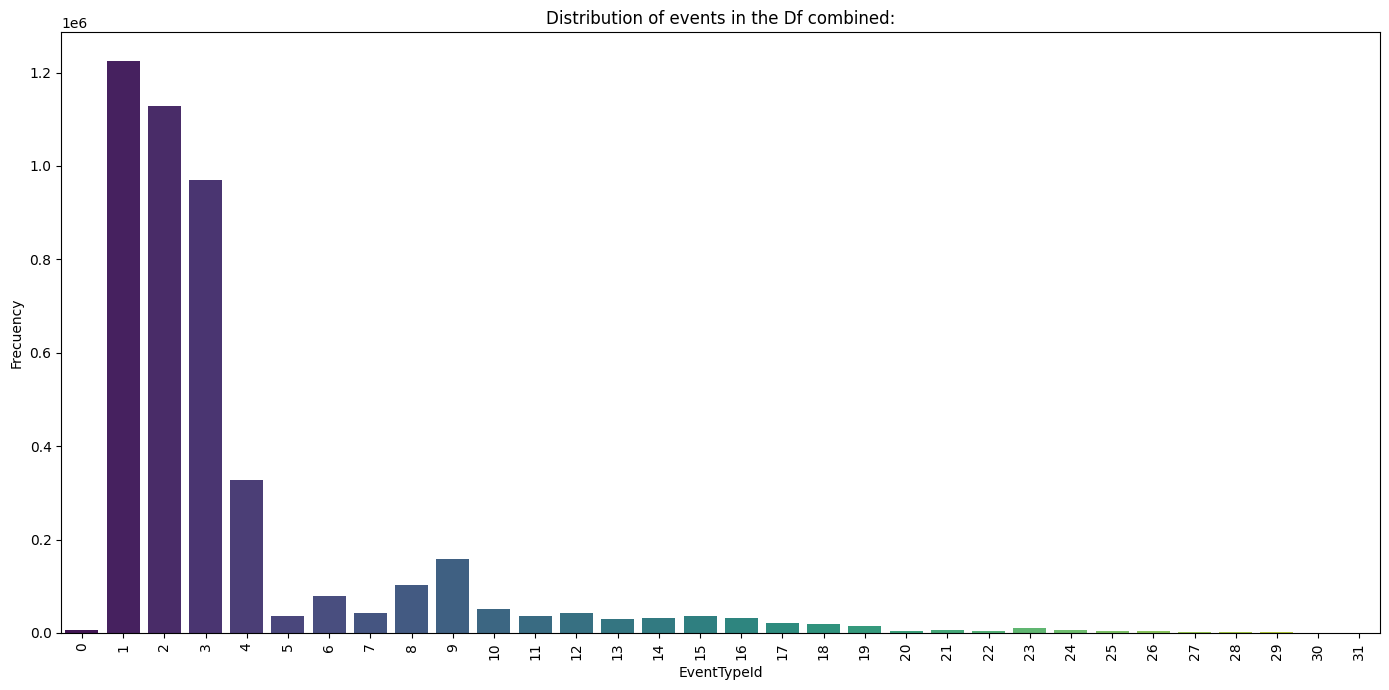

In [ ]:
# Lets explore the the distribution of the elements of the column EventTypeId in the df and plot a graph

# Calculate the frequency of each EventTypeId in the combined DataFrame
event_counts = df_combined['EventTypeId'].value_counts()

print("Distribution of events in the Df combined:")
print(event_counts)

# Plot the distribution
plt.figure(figsize=(14, 7))
sns.barplot(x=event_counts.index, y=event_counts.values, palette='viridis')
plt.xlabel('EventTypeId')
plt.ylabel('Frecuency')
plt.title('Distribution of events in the Df combined:')
plt.xticks(rotation=90) # Rotate labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
# For this 4 seasons we have

print(f"We have {games} games for the 4 years fo data given")

# For this 4 seasns we have #events

num_events = event_counts = df_combined['EventTypeId'].value_counts().sum()

print(f"\n And we have {num_events} events for {games} matches in 4 years in Liga MX")

We have 1364 games for the 4 years fo data given

 And we have 4442402 events for 1364 matches in 4 years in Liga MX


In [ ]:
# Lets see number of goals in the 4 years

goals = df_combined.IsGoal.sum()

print(f"We have {goals} goals for the 4 years fo data given")

We have 3641 goals for the 4 years fo data given
